In [1]:
import itertools
import json
import os
from datetime import timedelta
import time
from sklearn.metrics import accuracy_score
import pandas as pd
import cv2

# My modules
from types import SimpleNamespace
from utils import set_seeds
from config import Configuration
from train_manager import TrainManager
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
def plot_confusion_matrix(cm, class_names):
    """
    https://www.tensorflow.org/tensorboard/image_summaries#building_an_image_classifier
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [16]:
def run_inference(experiment_name, tta, weight_avg, kaggle, config):
    experiment_dir = os.path.abspath(config.save_dir + f'/{experiment_name}')

    if not kaggle: 
        with open(experiment_dir + '/experiment_config.json', 'r') as f:
            config = json.load(f, object_hook=lambda d: SimpleNamespace(**d))
            set_seeds(config.seed)
        df = pd.read_csv(experiment_dir + '/holdout.csv', engine='python')
    else: 
        df = pd.DataFrame()
        df['image_id'] = list(os.listdir(config.test_img_dir))
    
    if config.num_workers > 0:
        cv2.setNumThreads(0)

    inference_start = time.time()
    
    # get predictions... folds = None just means ensemble inference
    manager = TrainManager(folds_df=None, holdout_df=df, config=config,
                           experiment_dir=experiment_dir, experiment_name=experiment_name, kaggle=kaggle,
                          finetune=False, freeze_bn=False, freeze_feature_extractor=False)
    manager.test(tta, weight_avg, mode='vote')
    

    print(f"Inference time: {str(timedelta(seconds=time.time() - inference_start))}")
    if not kaggle:
        acc = accuracy_score(y_true=df.label.values, y_pred=manager.final_test_predictions)
        print("Ensemble holdout accuracy", acc)
        plot_confusion_matrix(manager.test_confusion_matrix.detach().cpu().numpy(), class_names=[i for i in range(config.num_classes)])

    if kaggle:
         # make submission file
        submission = pd.DataFrame()
        submission['image_id'] = df['image_id']
        submission['label'] = manager.test_predictions_ensembled
        submission.to_csv('submission.csv', index=False)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


Testing: 100%|██████████| 51/51 [00:16<00:00,  3.10it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.8773, device='cuda:0'),
 'test_acc_weighted': tensor(0.7786, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 51/51 [00:16<00:00,  3.06it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.8832, device='cuda:0'),
 'test_acc_weighted': tensor(0.7811, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 51/51 [00:16<00:00,  3.05it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.8866, device='cuda:0'),
 'test_acc_weighted': tensor(0.7784, device='cuda:0')}
-------------------------------------------

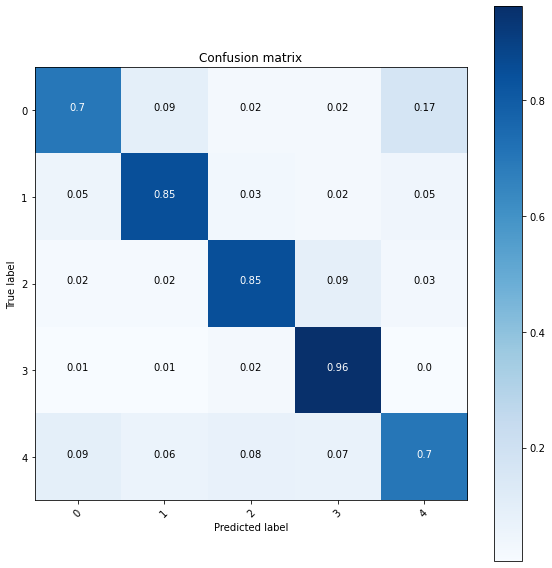

In [17]:
run_inference(experiment_name='sgd_coswarm_bnf_bitemp_smooth_weighted_t1=0.3_t2=1.0_89-53',
              tta=False, weight_avg=False,
              kaggle=False, config=Configuration())